# TDT17 Mini Project
### Road Crack Detection

The goal of this notebook is to help the road authorities in Trønderlag, Norway by detecting cracks in the road
on provided images. The goal is to create a model that can detect cracks in the road, making it easier for the
authorities to find and repair them. We will use the mean average precision (mAP) as a metric to evaluate the
performance of our model.

#### Importing libraries

In [54]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import lxml.etree as ET
import random
from tqdm import tqdm

#### Setting up data paths

In [55]:
train_path = "./Norway/train/"
test_path = "./Norway/test/"
train_images_path = os.path.join(train_path, "images")
test_images_path = os.path.join(test_path, "images")
train_annotations_path = os.path.join(train_path, "annotations/xmls")

#### Fetching data from file
This will read the XML in the annotations folder and create a dictionary with the data valuable for the model. The data is transformed into a dictionary with the following format:
```python
{'image': {
    'path': './Norway/train/images/Norway_000005.jpg',
    'width': 3650, 
    'height': 2044}, 
'boxes': [
    {'type': 1, 'coords': (1140.27, 1164.62, 1280.35, 1199.79)}, 
    {'type': 1, 'coords': (155.59, 1601.83, 777.02, 2034.32)}, 
    {'type': 4, 'coords': (1190.21, 1354.48, 1290.52, 1406.12)}, 
    {'type': 4, 'coords': (1286.54, 1427.97, 1376.92, 1455.78)}, 
    {'type': 4, 'coords': (1472.27, 1202.5, 1550.7, 1232.32)}
}
```


In [56]:
def elem2dict(node, attributes=True):
    """
    Convert an lxml.etree node tree into a dict.
    """
    result = {}
    if attributes:
        for item in node.attrib.items():
            key, result[key] = item

    for element in node.iterchildren():
        # Remove namespace prefix
        key = element.tag.split('}')[1] if '}' in element.tag else element.tag

        # Process element as tree element if the inner XML contains non-whitespace content
        if element.text and element.text.strip():
            value = element.text
        else:
            value = elem2dict(element)
        if key in result:
            if type(result[key]) is list:
                result[key].append(value)
            else:
                result[key] = [result[key], value]
        else:
            result[key] = value
    return result


# Converting from xml to dictionary
train_xml = [ET.parse(os.path.join(train_annotations_path, x)).getroot()
             for x in os.listdir(train_annotations_path)]
train_dicts = [elem2dict(x) for x in train_xml]

# Converting from dictionary to valid data format


def dict2data(dict):
    holetypes = {"D00": 0, "D10": 1, "D20": 2, "D40": 3}
    image = {"path": os.path.join(train_images_path, dict["filename"]), "width": int(
        dict["size"]["width"]), "height": int(dict["size"]["height"])}
    boxes = []
    if "object" in dict:
        if not type(dict["object"]) is list:
            dict["object"] = [dict["object"]]
        for object in dict["object"]:
            box = {}
            box["type"] = holetypes[object["name"]]
            box["coords"] = [float(object["bndbox"]["xmin"]),
                              float(object["bndbox"]["ymin"]),
                              float(object["bndbox"]["xmax"]),
                              float(object["bndbox"]["ymax"])]
            boxes.append(box)
    else:
        boxes = []
    return {"image": image, "boxes": boxes}


train_data_dict = [dict2data(x) for x in train_dicts]
print(len(train_data_dict))
train_data_dict = [x for x in train_data_dict if len(x["boxes"]) > 0][:100]
print(len(train_data_dict))

8161
100


#### Visualizing some data to check if it is correct

./Norway/train/images\Norway_000073.jpg


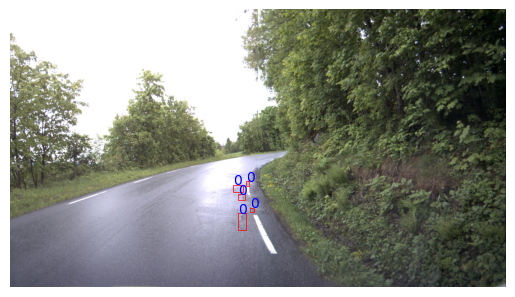

./Norway/train/images\Norway_000085.jpg


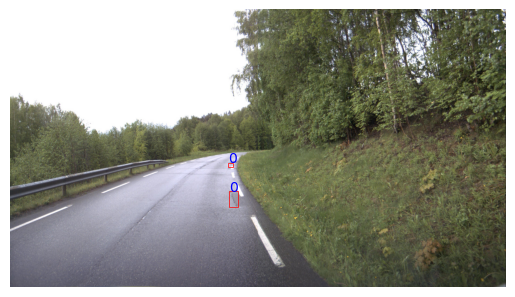

./Norway/train/images\Norway_000028.jpg


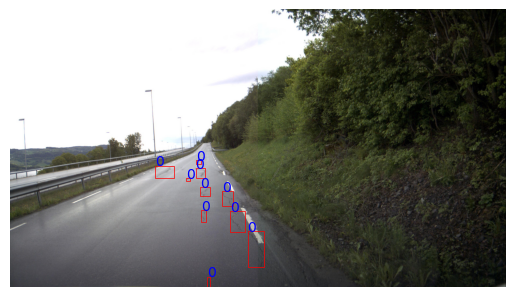

./Norway/train/images\Norway_000032.jpg


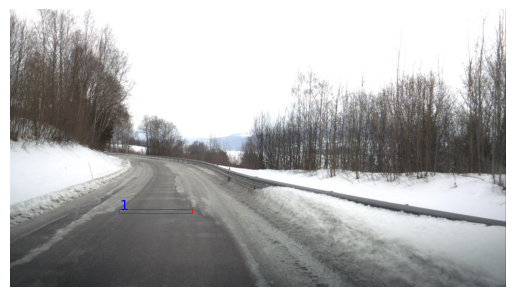

./Norway/train/images\Norway_000172.jpg


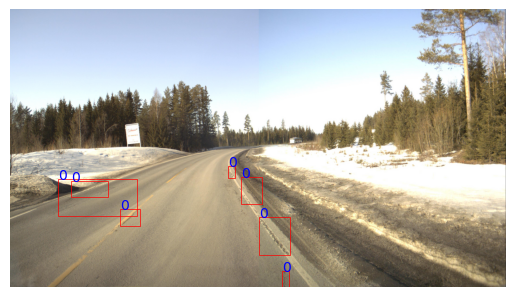

In [57]:
samples = []
while len(samples) < 5:
    data = random.choice(train_data_dict)
    if data["boxes"] is not None:
        samples.append(data)

for data in samples:
    image = Image.open(data["image"]["path"])
    print(data["image"]["path"])
    boxes = data["boxes"]
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()
    for box in boxes:
        xmin, ymin, xmax, ymax = box["coords"]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                             ymax - ymin, fill=False, color="red")
        ax.add_patch(rect)
        plt.text(xmin, ymin, box["type"], color="blue")
        plt.axis("off")
    plt.show()

    

#### Creating a dataset class

In [58]:
class NorwayDataset(torch.utils.data.Dataset):
    def __init__(self, root, image_transforms, target_transforms):
        self.root = root
        self.image_transforms = image_transforms
        self.target_transforms = target_transforms
        self.data = train_data_dict

    def __getitem__(self, idx):
        img_path = self.data[idx]["image"]["path"]
        img = Image.open(img_path).convert("RGB")
        boxes = []
        labels = []
        for box in self.data[idx]["boxes"]:
            boxes.append(box["coords"])
            labels.append(box["type"])
        
        boxes = np.array(boxes)
        labels = np.array(labels)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        if(len(boxes) > 0):
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = 0

        target = {}
        target["boxes"] = torch.as_tensor(boxes)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = torch.as_tensor(area)
        target["iscrowd"] = iscrowd

        if self.target_transforms is not None and len(boxes) > 0:
            target = self.target_transforms(target, (self.data[idx]["image"]["height"],self.data[idx]["image"]["width"]))
            boxes = target["boxes"]
            target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            
        if self.image_transforms is not None:
            img = self.image_transforms(img)


        return img, target
    
    def __len__(self):
        return len(self.data)




#### Creating transform for data

In [59]:
import torchvision.transforms as transforms
image_height = 285
image_width = 400


image_transform = transforms.Compose([
            transforms.Resize((image_height, image_width)),
            transforms.ToTensor()
        ])

def target_transforms(target, shape):
    height_scale, width_scale = shape[0]/image_height, shape[1]/image_width
    target["boxes"][:, 0] /= width_scale
    target["boxes"][:, 1] /= height_scale
    target["boxes"][:, 2] /= width_scale
    target["boxes"][:, 3] /= height_scale

    return target

#### Resizing and train test split

In [60]:
test_split_ratio = 0.25

# train test split on 25% (6 to 2)
train_data = train_data_dict[:int(len(train_data_dict) * (1 - test_split_ratio))]
validate_data = train_data_dict[int(len(train_data_dict) * (1 - test_split_ratio)):]


train_resized = NorwayDataset(train_data, image_transforms = image_transform, target_transforms = target_transforms)
validate_resized = NorwayDataset(validate_data, image_transforms = image_transform ,target_transforms= target_transforms)

#### Creating DataLoaders for training and validation

In [61]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_resized, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)
validate_loader = torch.utils.data.DataLoader(validate_resized, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [62]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 4  
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


c:\Users\noran\anaconda3\envs\airbuss\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\noran\anaconda3\envs\airbuss\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import time
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# DEVICE = torch.device('cpu')
plt.style.use('ggplot')
model.train()
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        desc= ""
        for key,value in loss_dict.items():
            desc+=f"{key}: {value:.4f} "
        losses = sum(loss for loss in loss_dict.values())
        
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=desc+f"Loss: {loss_value:.4f}")
    return train_loss_list

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
#             print(targets)
            loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [64]:
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

In [65]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [66]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# name to save the trained model with
MODEL_NAME = 'model'




EPOCH 1 of 10
Training


loss_classifier: 1.4585 loss_box_reg: 0.0256 loss_objectness: 4.3294 loss_rpn_box_reg: 0.3781 Loss: 6.1917:   8%|▊         | 1/13 [00:05<01:06,  5.57s/it]


KeyboardInterrupt: 

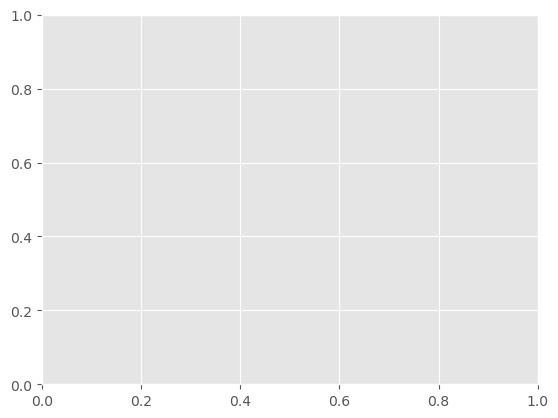

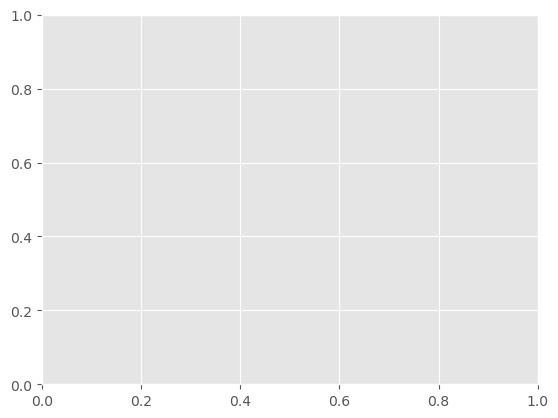

In [ ]:
NUM_EPOCHS = 10
SAVE_MODEL_EPOCH = 5
OUT_DIR = "./gnome_output"
SAVE_PLOTS_EPOCH = 5

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(validate_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        print('SAVING MODEL COMPLETE...\n')

    if (epoch+1) % SAVE_PLOTS_EPOCH == 0: # save loss plots after n epochs
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")
        print('SAVING PLOTS COMPLETE...')

    if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
        train_ax.plot(train_loss, color='blue')
        train_ax.set_xlabel('iterations')
        train_ax.set_ylabel('train loss')
        valid_ax.plot(val_loss, color='red')
        valid_ax.set_xlabel('iterations')
        valid_ax.set_ylabel('validation loss')
        figure_1.savefig(f"{OUT_DIR}/train_loss_{epoch+1}.png")
        figure_2.savefig(f"{OUT_DIR}/valid_loss_{epoch+1}.png")

        torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")

    plt.close('all')
    # sleep for 5 seconds after each epoch
    time.sleep(5)

In [67]:
### Loading model from checkpoint
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) 
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('./gnome_output/model10.pth'))
model.to(device=DEVICE)

c:\Users\noran\anaconda3\envs\airbuss\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\noran\anaconda3\envs\airbuss\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [68]:
test_image = "./Norway/train/images/Norway_000027.jpg"
imgage = Image.open(test_image).convert("RGB")
img = image_transform(imgage)

model.eval()
pred = model([img.to(DEVICE)])

In [69]:
pred = pred[0]

In [70]:
print(pred)

{'boxes': tensor([[116.7422, 202.4840, 148.8087, 207.2184],
        [127.3334, 202.7256, 154.5535, 206.6554]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.0639, 0.0509], device='cuda:0', grad_fn=<IndexBackward0>)}


[[116.74224 202.484   148.80875 207.21844]
 [127.33339 202.72563 154.55353 206.6554 ]]


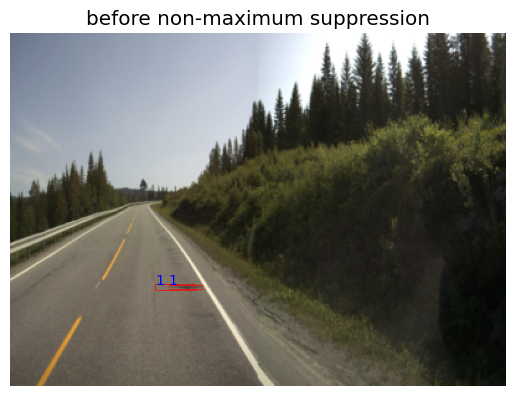

In [71]:
image = np.array(img.permute(1,2,0))
boxes = pred["boxes"].cpu().detach().numpy()
plt.figure()
plt.imshow(image)
ax = plt.gca()
print(boxes)
for i, box in enumerate(boxes[:5]):
    xmin, ymin, xmax, ymax = box
    rect = plt.Rectangle((xmin, ymin), xmax - xmin,ymax - ymin, fill=False, color="red")
    ax.add_patch(rect)
    plt.text(xmin, ymin, pred["labels"].cpu().detach().numpy()[i], color="blue")
    plt.axis("off")
    plt.title("before non-maximum suppression")
plt.show()

In [72]:
nms_pred = torchvision.ops.nms(pred['boxes'], pred['scores'], 0.45).cpu()

[array([116.74224, 202.484  , 148.80875, 207.21844], dtype=float32)]
[116.74224 202.484   148.80875 207.21844]


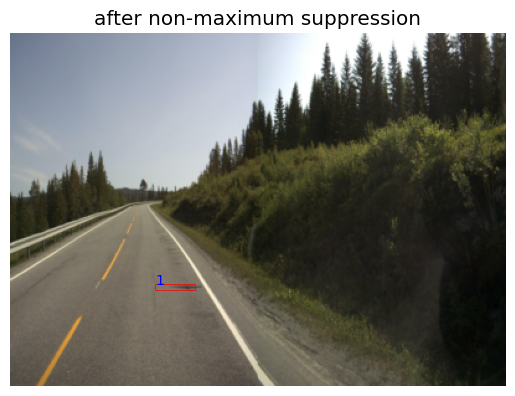

In [73]:
image = np.array(img.permute(1,2,0))
boxes = []
for i in range(len(nms_pred)):
    boxes.append(pred["boxes"][nms_pred[i]].cpu().detach().numpy())
plt.figure()
plt.imshow(image)
ax = plt.gca()
print(boxes)
for i, box in enumerate(boxes[:5]):
    print(box)
    xmin, ymin, xmax, ymax = box
    rect = plt.Rectangle((xmin, ymin), xmax - xmin,ymax - ymin, fill=False, color="red")
    ax.add_patch(rect)
    plt.text(xmin, ymin, pred["labels"].cpu().detach().numpy()[i], color="blue")
    plt.axis("off")
    plt.title("after non-maximum suppression")
plt.show()

In [74]:
def scaled_up_boxes(og_shape, pred):
    pred = pred["boxes"].cpu().detach().numpy()
    width_scale = og_shape[1] / image_width
    height_scale = og_shape[0] / image_height
    pred[:, 0] *= width_scale
    pred[:, 1] *= height_scale
    pred[:, 2] *= width_scale
    pred[:, 3] *= height_scale
    return pred 

In [75]:
imgage_shape = np.array(imgage).shape
scaled_pred_boxes = scaled_up_boxes([imgage_shape[0],imgage_shape[1]], pred)

(2035, 4040, 3)


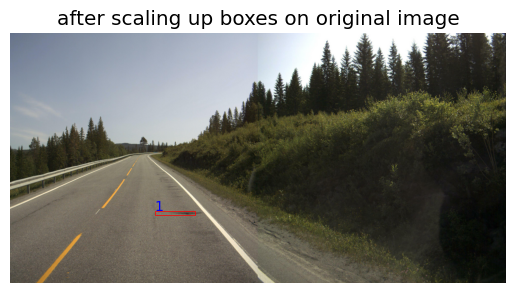

In [76]:
image = np.array(imgage)
print(image.shape)
boxes = []

for i in range(len(nms_pred)):
    boxes.append(scaled_pred_boxes[i])

plt.figure()
plt.imshow(image)
ax = plt.gca()

for i, box in enumerate(boxes[:5]):
    xmin, ymin, xmax, ymax = box
    rect = plt.Rectangle((xmin, ymin), xmax - xmin,ymax - ymin, fill=False, color="red")
    ax.add_patch(rect)
    plt.text(xmin, ymin, pred["labels"].cpu().detach().numpy()[i], color="blue")
    plt.axis("off")
    plt.title("after scaling up boxes on original image")
plt.show()

In [77]:
# Testing on test images

test_image = "./Norway/test/images/Norway_008165.jpg"
imgage = Image.open(test_image).convert("RGB")
img = image_transform(imgage)

model.eval()
pred = model([img.to(DEVICE)])
pred = pred[0]

In [78]:
nms_pred = torchvision.ops.nms(pred['boxes'], pred['scores'], 0.45).cpu()
imgage_shape = np.array(imgage).shape
scaled_pred_boxes = scaled_up_boxes([imgage_shape[0],imgage_shape[1]], pred)

(2035, 4040, 3)


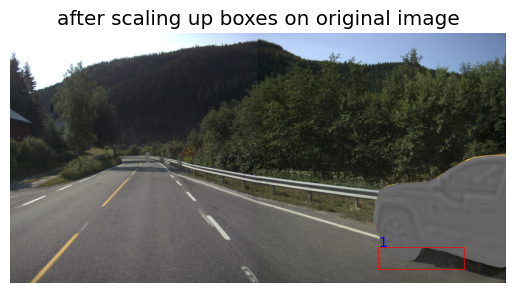

In [79]:
image = np.array(imgage)
print(image.shape)
boxes = []

for i in range(len(nms_pred)):
    boxes.append(scaled_pred_boxes[i])

plt.figure()
plt.imshow(image)
ax = plt.gca()

for i, box in enumerate(boxes[:5]):
    xmin, ymin, xmax, ymax = box
    rect = plt.Rectangle((xmin, ymin), xmax - xmin,ymax - ymin, fill=False, color="red")
    ax.add_patch(rect)
    plt.text(xmin, ymin, pred["labels"].cpu().detach().numpy()[i], color="blue")
    plt.axis("off")
    plt.title("after scaling up boxes on original image")
plt.show()

In [80]:
# # Make submission file
# test_images_path = os.listdir('./Norway/test/images/')[:10]
# labels = []
# boxes = []

# model.eval()
# for i in tqdm(range(len(test_images_path))):
#     image = Image.open('./Norway/test/images/'+test_images_path[i]).convert("RGB")
#     img = image_transform(image)
#     pred = model([img.to(DEVICE)])[0]
#     print(test_images_path[i])
#     for label in range(len(pred['labels'])):
#         predictions.append(pred['labels'].cpu().detach().numpy()[label])
#         boxes = ['boxes'].cpu().detach().numpy()[label]

            




# df = pd.DataFrame()
# df['ImageId'] = test_images_path
# df['PredictionString'] = predictions
